# Merging, Splicing and Blending Time Series
This tutorial demonstrates the usage and difference between `ts_merge` and `ts_splice`, two methods for folding together time series into a combined data structure.

- **`ts_merge`** blends multiple time series together based on priority, optionally filling missing values in higher priority series with entries from lower priority. It potentially uses all the input series at all timestamps. See the [`strict_priority`](#ts_merge-strict-priority-option) option below for advanced control over nan-filling between priorities.
- **`ts_splice`** stitches together time series in sequential time **blocks** without mixing values.

We will describe the effect on regularly sampled series (which have the  `freq` attribute) and on irregular. We will also  explore the **`names`** argument, which controls how columns are selected or renamed in the merging/splicing process. There is a file-level command line tools for this as well in the `dms_datastore` package.

## Prioritized filling on regular series
Let's begin by showing how `ts_merge` and `ts_splice` fold together two regular series but gappy 
series on a prioritized basis.

Here are the sample series:

In [23]:
import pandas as pd
import numpy as np
from vtools import ts_merge, ts_splice
# ========================================
# Creating Regular Time Series (1D Frequency with Missing Data)
# ========================================
idx1 = pd.date_range("2023-01-01", periods=10, freq="1D")
idx2 = pd.date_range("2023-01-01", periods=12, freq="1D")
idx3 = pd.date_range("2022-12-31", periods=14, freq="1D")

series1 = pd.Series([1, np.nan, 3, np.nan, 5, 6, np.nan, 8, 9, 10], index=idx1, name="A")
series2 = pd.Series([np.nan, 2, np.nan, 4, np.nan, np.nan, 7, np.nan, np.nan, np.nan,3.,4.], index=idx2, name="A")
series3 = pd.Series([1000.,1001., 1002., np.nan, 1004., np.nan, np.nan, 1007., np.nan, np.nan, np.nan,1005.,1006.,1007.], index=idx3, name="A")

print("Series 1 (Primary):")
display(series1)

print("\nSeries 2 (Secondary - Fills Gaps):")
display(series2)

print("\nSeries 3 (Tertiary - Fills Gaps):")
display(series3)





Series 1 (Primary):


2023-01-01     1.0
2023-01-02     NaN
2023-01-03     3.0
2023-01-04     NaN
2023-01-05     5.0
2023-01-06     6.0
2023-01-07     NaN
2023-01-08     8.0
2023-01-09     9.0
2023-01-10    10.0
Freq: D, Name: A, dtype: float64


Series 2 (Secondary - Fills Gaps):


2023-01-01    NaN
2023-01-02    2.0
2023-01-03    NaN
2023-01-04    4.0
2023-01-05    NaN
2023-01-06    NaN
2023-01-07    7.0
2023-01-08    NaN
2023-01-09    NaN
2023-01-10    NaN
2023-01-11    3.0
2023-01-12    4.0
Freq: D, Name: A, dtype: float64


Series 3 (Tertiary - Fills Gaps):


2022-12-31    1000.0
2023-01-01    1001.0
2023-01-02    1002.0
2023-01-03       NaN
2023-01-04    1004.0
2023-01-05       NaN
2023-01-06       NaN
2023-01-07    1007.0
2023-01-08       NaN
2023-01-09       NaN
2023-01-10       NaN
2023-01-11    1005.0
2023-01-12    1006.0
2023-01-13    1007.0
Freq: D, Name: A, dtype: float64

And here is what it looks like spliced instead of merged.

In [24]:
# ========================================
# 2️⃣ Using `ts_merge()` with Prioritization
# ========================================
merged_series = ts_merge((series1, series2, series3))
print("\nMerged Series with Prioritization:")
display(merged_series)


Merged Series with Prioritization:


2022-12-31    1000.0
2023-01-01       1.0
2023-01-02       2.0
2023-01-03       3.0
2023-01-04       4.0
2023-01-05       5.0
2023-01-06       6.0
2023-01-07       7.0
2023-01-08       8.0
2023-01-09       9.0
2023-01-10      10.0
2023-01-11       3.0
2023-01-12       4.0
2023-01-13    1007.0
Freq: D, Name: A, dtype: float64

## Splicing
Splicing marches through the prioritized list of input time series and exclusively uses values for the higher priority series one during the entire span of that series. 

In [25]:
spliced_series = ts_splice((series1, series2, series3))
print("\nSpliced Series with Prioritization and default `prefer last`:")
display(spliced_series)
spliced_first = ts_splice((series1, series2, series3),transition="prefer_first")
print("\nSpliced Series with Prioritization, Prefer first:")
display(spliced_first)


Spliced Series with Prioritization and default `prefer last`:


2022-12-31    1000.0
2023-01-01    1001.0
2023-01-02    1002.0
2023-01-03       NaN
2023-01-04    1004.0
2023-01-05       NaN
2023-01-06       NaN
2023-01-07    1007.0
2023-01-08       NaN
2023-01-09       NaN
2023-01-10       NaN
2023-01-11    1005.0
2023-01-12    1006.0
2023-01-13    1007.0
Freq: D, Name: A, dtype: float64


Spliced Series with Prioritization, Prefer first:


2023-01-01       1.0
2023-01-02       NaN
2023-01-03       3.0
2023-01-04       NaN
2023-01-05       5.0
2023-01-06       6.0
2023-01-07       NaN
2023-01-08       8.0
2023-01-09       9.0
2023-01-10      10.0
2023-01-11       3.0
2023-01-12       4.0
2023-01-13    1007.0
Freq: D, Name: A, dtype: float64

## Irregular series

Now we will look at some irregular series and see the difference in output from ts_merge (which shuffles) and ts_splice (which exclusively uses values from one series at a time based on the span of the series and its priority)

In [26]:

# ========================================
# 3️⃣ Creating Irregular Time Series (No Freq Attribute)
# ========================================
idx_irreg1 = pd.to_datetime(["2023-01-01", "2023-01-03", "2023-01-07", "2023-01-10"])
idx_irreg2 = pd.to_datetime(["2023-01-02", "2023-01-04", "2023-01-08", "2023-01-11"])

series_irreg1 = pd.Series([1, np.nan, 3, 4], index=idx_irreg1, name="A")
series_irreg2 = pd.Series([10, 20, np.nan, 40], index=idx_irreg2, name="A")

print("\nIrregular Series 1:")
display(series_irreg1)

print("\nIrregular Series 2:")
display(series_irreg2)

# ========================================
# 4️⃣ Using `ts_merge()` with Irregular Time Series
# ========================================
merged_irregular = ts_merge((series_irreg1, series_irreg2))
print("\nMerged Irregular Series (May Shuffle Timestamps):")
display(merged_irregular)

# ========================================
# 5️⃣ Using `ts_splice()` with Irregular Time Series
# ========================================
spliced_irregular = ts_splice((series_irreg1, series_irreg2), transition="prefer_last")
print("\nSpliced Irregular Series (prefer_last):")
display(spliced_irregular)


Irregular Series 1:


2023-01-01    1.0
2023-01-03    NaN
2023-01-07    3.0
2023-01-10    4.0
Name: A, dtype: float64


Irregular Series 2:


2023-01-02    10.0
2023-01-04    20.0
2023-01-08     NaN
2023-01-11    40.0
Name: A, dtype: float64


Merged Irregular Series (May Shuffle Timestamps):


2023-01-01     1.0
2023-01-02    10.0
2023-01-03     NaN
2023-01-04    20.0
2023-01-07     3.0
2023-01-08     NaN
2023-01-10     4.0
2023-01-11    40.0
Name: A, dtype: float64


Spliced Irregular Series (prefer_last):


2023-01-01     1.0
2023-01-02    10.0
2023-01-04    20.0
2023-01-08     NaN
2023-01-11    40.0
Name: A, dtype: float64

## `Names` argument

Finally let's look at some more intricate examples with mixed series and dataframes with differing numbers of columns and see how `names` can be used to make selections or unify poorly coordinated labels. Here are the series:

In [27]:
import pandas as pd
import numpy as np
from vtools import ts_merge, ts_splice  # Assuming these functions are in merge.py

# Create irregular time series
idx1 = pd.date_range("2023-01-01", periods=5, freq="2D")
idx2 = pd.date_range("2023-01-02", periods=5, freq="2D")

series1 = pd.Series([1, np.nan, 3, 4, 5], index=idx1, name="A")
series2 = pd.Series([10, 20, 30, np.nan, 50], index=idx2, name="B")

df1 = pd.DataFrame({"A": [1, np.nan, 3, 4, 5], "B": [10, 20, 30, 40, 50]}, index=idx1)
df2 = pd.DataFrame({"A": [10, 20, np.nan, 40, 50], "B": [100, 200, np.nan, 400, 500]}, index=idx2)
df3 = pd.DataFrame({"A": [310, 320, np.nan, 340, np.nan], 
                    "B": [100, 200, np.nan, 400, 500],
                    "C": [3100, 3200, np.nan, 3400, 3500]
                    }, index=idx2)

# Display Data
print("Series 1:")
display(series1)

print("Series 2:")
display(series2)

print("DataFrame 1:")
display(df1)

print("DataFrame 2:")
display(df2)

print("DataFrame 3:")
display(df3)


Series 1:


2023-01-01    1.0
2023-01-03    NaN
2023-01-05    3.0
2023-01-07    4.0
2023-01-09    5.0
Freq: 2D, Name: A, dtype: float64

Series 2:


2023-01-02    10.0
2023-01-04    20.0
2023-01-06    30.0
2023-01-08     NaN
2023-01-10    50.0
Freq: 2D, Name: B, dtype: float64

DataFrame 1:


,A,B
2023-01-01,1.0,10
2023-01-03,NaN,20
2023-01-05,3.0,30
2023-01-07,4.0,40
2023-01-09,5.0,50


DataFrame 2:


,A,B
2023-01-02,10.0,100.0
2023-01-04,20.0,200.0
2023-01-06,NaN,NaN
2023-01-08,40.0,400.0
2023-01-10,50.0,500.0


DataFrame 3:


,A,B,C
2023-01-02,310.0,100.0,3100.0
2023-01-04,320.0,200.0,3200.0
2023-01-06,NaN,NaN,NaN
2023-01-08,340.0,400.0,3400.0
2023-01-10,NaN,500.0,3500.0


Here are some example usage:

In [28]:
# Example: Using `names` to rename output columns
print("Original univariate series")
print(series1)
print(series2)

# Merging univariate with different names and using names to rename
merged_series_named = ts_merge((series1, series2), names=["C"])
print("Merged univariate series renamed:")
display(merged_series_named)


# Select specific columns in DataFrame
try:
    merged_df_named = ts_merge((df1, df2, df3), names=None)
except:
    print("Merged DataFrame without Selected Columns (names=None) results in an error if the columns don't match")
#display(merged_df_named)

# Select specific columns in DataFrame
merged_df_named = ts_merge((df1, df2), names=None)
print("Merged DataFrame without selected columns (names=None) for input DataFrames with matched columns:")
display(merged_df_named)


# Select specific columns in DataFrame
merged_df_named = ts_merge((df1, df2, df3), names=["A"])
print("Merged DataFrame with Selected Columns A merges that column ([A,B] would have been OK too)")
display(merged_df_named)


# Rename column in splicing
spliced_series_named = ts_splice((series1, series2), names="Renamed_A", transition="prefer_last")
print("Spliced Series with Renamed Column:")
display(spliced_series_named)


Original univariate series
2023-01-01    1.0
2023-01-03    NaN
2023-01-05    3.0
2023-01-07    4.0
2023-01-09    5.0
Freq: 2D, Name: A, dtype: float64
2023-01-02    10.0
2023-01-04    20.0
2023-01-06    30.0
2023-01-08     NaN
2023-01-10    50.0
Freq: 2D, Name: B, dtype: float64
Merged univariate series renamed:


2023-01-01     1.0
2023-01-02    10.0
2023-01-03     NaN
2023-01-04    20.0
2023-01-05     3.0
2023-01-06    30.0
2023-01-07     4.0
2023-01-08     NaN
2023-01-09     5.0
2023-01-10    50.0
Name: C, dtype: float64

Merged DataFrame without Selected Columns (names=None) results in an error if the columns don't match
Merged DataFrame without selected columns (names=None) for input DataFrames with matched columns:


,A,B
2023-01-01,1.0,10.0
2023-01-02,10.0,100.0
2023-01-03,NaN,20.0
2023-01-04,20.0,200.0
2023-01-05,3.0,30.0
2023-01-06,NaN,NaN
2023-01-07,4.0,40.0
2023-01-08,40.0,400.0
2023-01-09,5.0,50.0
2023-01-10,50.0,500.0


Merged DataFrame with Selected Columns A merges that column ([A,B] would have been OK too)


,A
2023-01-01,1.0
2023-01-02,10.0
2023-01-03,NaN
2023-01-04,20.0
2023-01-05,3.0
2023-01-06,NaN
2023-01-07,4.0
2023-01-08,40.0
2023-01-09,5.0
2023-01-10,50.0


Spliced Series with Renamed Column:


2023-01-01     1.0
2023-01-02    10.0
2023-01-04    20.0
2023-01-06    30.0
2023-01-08     NaN
2023-01-10    50.0
Name: Renamed_A, dtype: float64

## Summary
- **Use `ts_merge`** when you want to blend time series together, filling missing values in order of priority.
- **Use `ts_splice`** when you want to keep each time series separate and transition from one to another based on time.
- **The `names` argument** allows you to rename output columns or select specific columns when merging/splicing DataFrames.

This notebook provides a clear comparison to help you decide which method best suits your use case.


# `ts_merge`: strict priority option
**New option**: `strict_priority` (default `False`) enforces that a higher‑priority series dominates between its `first_valid_index` and `last_valid_index`.

**Semantics**
- Per **column**, define the dominance window as `[first_valid_index, last_valid_index]`.
- Within that window, lower‑priority series are **masked**, even if the higher‑priority value is `NaN`.
- Outside those windows, merging is unchanged and lower priority may contribute.
- With irregular inputs, timestamps that exist **only** in lower‑priority series **and** are fully masked inside a dominance window are dropped; timestamps from the top series' index are preserved even if all‑`NaN`.

**`names` behavior** is unchanged.
### Example 1 — Series with interior `NaN`

```python
import numpy as np, pandas as pd
from vtools.functions.merge import ts_merge

idx1 = pd.date_range("2023-01-01", periods=5, freq="D")
idx2 = pd.date_range("2023-01-03", periods=5, freq="D")
s1 = pd.Series([1, 2, np.nan, 4, 5], index=idx1, name="A")
s2 = pd.Series([10, 20, 30, np.nan, 50], index=idx2, name="A")

ts_merge((s1, s2))                      # default
ts_merge((s1, s2), strict_priority=True)
```
### Example 2 — Two columns, per‑column dominance

```python
idx1 = pd.date_range("2023-01-01", periods=5, freq="D")
idx2 = pd.date_range("2023-01-03", periods=5, freq="D")
df1 = pd.DataFrame({"A":[1., np.nan, 3., 4., 5.]}, index=idx1)
df1["B"] = df1["A"]
df1.loc[idx1[2], "B"] = np.nan  # interior NaN in high‑priority B
df2 = pd.DataFrame({"A":[10., 20., np.nan, 40., 50.]}, index=idx2)
df2["B"] = df2["A"]

ts_merge((df1, df2), strict_priority=True)[["A","B"]]
```
### Example 3 — Irregular inputs

```python
idx1 = pd.to_datetime(["2023-01-01","2023-01-03","2023-01-07","2023-01-10"])
idx2 = pd.to_datetime(["2023-01-02","2023-01-04","2023-01-08","2023-01-11"])
s1 = pd.Series([1.,2.,3.,4.], index=idx1, name="A")
s2 = pd.Series([10.,20.,30.,40.], index=idx2, name="A")

ts_merge((s1, s2), strict_priority=True)
```


In [29]:
import numpy as np, pandas as pd
from vtools.functions.merge import ts_merge

# Example 1
idx1 = pd.date_range("2023-01-01", periods=5, freq="D")
idx2 = pd.date_range("2023-01-03", periods=5, freq="D")
s1 = pd.Series([1, 2, np.nan, 4, 5], index=idx1, name="A")
s2 = pd.Series([10, 20, 30, np.nan, 50], index=idx2, name="A")
print("Example 1 strict=False:")
print(ts_merge((s1, s2)))
print("Example 1 strict=True:")
print(ts_merge((s1, s2), strict_priority=True))

# Example 2
df1 = pd.DataFrame({"A":[1., np.nan, 3., 4., 5.]}, index=idx1)
df1["B"] = df1["A"]; df1.loc[idx1[2], "B"] = np.nan
df2 = pd.DataFrame({"A":[10., 20., np.nan, 40., 50.]}, index=idx2)
df2["B"] = df2["A"]
print("\nExample 2 strict=True:")
print(ts_merge((df1, df2), strict_priority=True)[["A","B"]])

# Example 3
idx1i = pd.to_datetime(["2023-01-01","2023-01-03","2023-01-07","2023-01-10"])
idx2i = pd.to_datetime(["2023-01-02","2023-01-04","2023-01-08","2023-01-11"])
s1i = pd.Series([1.,2.,3.,4.], index=idx1i, name="A")
s2i = pd.Series([10.,20.,30.,40.], index=idx2i, name="A")
print("\nExample 3 strict=True:")
print(ts_merge((s1i, s2i), strict_priority=True))


Example 1 strict=False:
2023-01-01     1.0
2023-01-02     2.0
2023-01-03    10.0
2023-01-04     4.0
2023-01-05     5.0
2023-01-06     NaN
2023-01-07    50.0
Freq: D, Name: A, dtype: float64
Example 1 strict=True:
2023-01-01     1.0
2023-01-02     2.0
2023-01-03     NaN
2023-01-04     4.0
2023-01-05     5.0
2023-01-06     NaN
2023-01-07    50.0
Freq: D, Name: A, dtype: float64

Example 2 strict=True:
               A     B
2023-01-01   1.0   1.0
2023-01-02   NaN   NaN
2023-01-03   3.0   NaN
2023-01-04   4.0   4.0
2023-01-05   5.0   5.0
2023-01-06  40.0  40.0
2023-01-07  50.0  50.0

Example 3 strict=True:
2023-01-01     1.0
2023-01-03     2.0
2023-01-07     3.0
2023-01-10     4.0
2023-01-11    40.0
Name: A, dtype: float64


## Blending near gaps: `ts_blend`

The functions shown above (`ts_merge` and `ts_splice`) perform *hard* selections:

- **`ts_merge`** picks the first non-NaN value in priority order at each timestamp.
- **`ts_splice`** constructs a piecewise record by switching sources at explicit transition times.

In some workflows, however, abrupt switches in the merged product create undesirable jumps.
Often the *higher-priority* series is preferred, but it may contain gaps. In those regions it is
useful to **fade in** the lower-priority series near the edges of gaps rather than switching
immediately.

`ts_blend` implements exactly that:

- Takes a list of Series/DataFrames (higher priority first).
- Aligns them onto a common union index.
- Inside gaps of the high-priority series: **falls back** to lower-priority data (just like `ts_merge`).
- On the *shoulders* of gaps: computes the **distance to the nearest gap** in the high-priority
  series and applies a smooth kernel.

For a gap-edge point with distance $d$ from the nearest NaN and a user-specified blending
radius $L$:

$$
\tilde t = \frac{L - d}{L}, \qquad
w_{\mathrm{lo}} = 0.5 \tilde t, \qquad
w_{\mathrm{hi}} = 1 - w_{\mathrm{lo}}.
$$

Thus:

- Points *at* the gap edge blend in up to **50%** of the lower-priority value.
- Points farther than `blend_length` away use **100%** of the high-priority value.
- Inside gaps, the lower-priority series is used exactly.
- If the lower-priority series is also missing at some point, the output remains NaN.

`blend_length` can be:

- an **integer** → interpreted as a *number of samples*, or
- a **timedelta-like string** (e.g. `"2h"`, `"1d"`) → interpreted as a time window
  (requires a regular `DatetimeIndex` with `.freq` set).

Setting `blend_length=None` makes `ts_blend` behave like a standard priority merge.


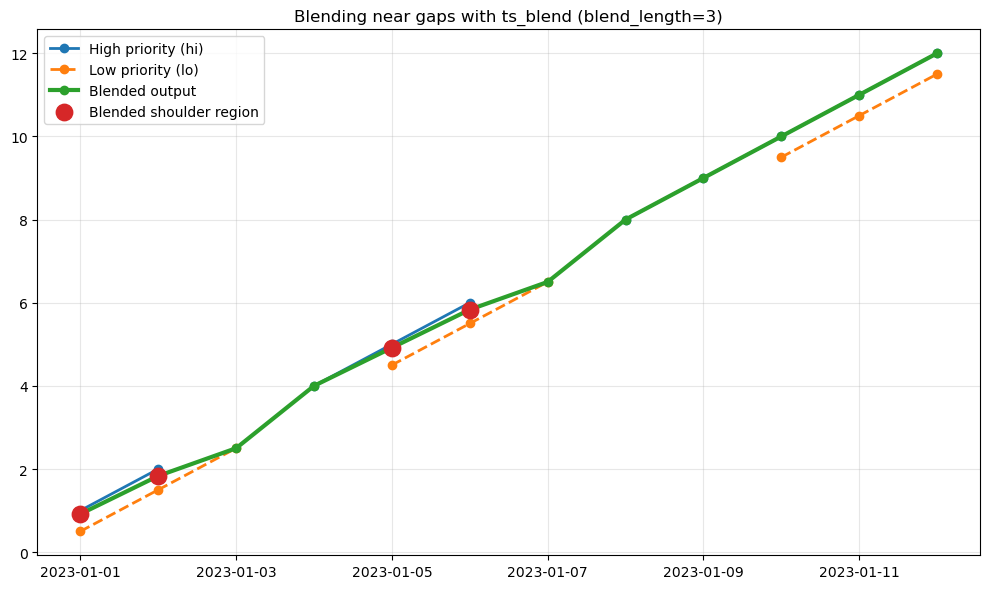

,hi,lo,blended
2023-01-01,1.0,0.5,0.916667
2023-01-02,2.0,1.5,1.833333
2023-01-03,NaN,2.5,2.500000
2023-01-04,4.0,NaN,4.000000
2023-01-05,5.0,4.5,4.916667
2023-01-06,6.0,5.5,5.833333
2023-01-07,NaN,6.5,6.500000
2023-01-08,8.0,NaN,8.000000
2023-01-09,9.0,NaN,9.000000
2023-01-10,10.0,9.5,10.000000


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vtools.functions.blend import ts_blend

# Example 12-point daily series
idx = pd.date_range("2023-01-01", periods=12, freq="D")

# High-priority with two gaps
hi = pd.Series(
    [1, 2, np.nan, 4, 5, 6, np.nan, 8, 9, 10, 11, 12],
    index=idx,
    name="hi",
)

# Low-priority with different gaps
lo = pd.Series(
    [0.5, 1.5, 2.5, np.nan, 4.5, 5.5, 6.5, np.nan, np.nan, 9.5, 10.5, 11.5],
    index=idx,
    name="lo",
)

blend_length = 3   # 3-sample blending shoulder

out = ts_blend((hi, lo), blend_length=blend_length,names="blended")

# Identify shoulder points where blending had an effect
shoulder_mask = (~hi.isna()) & (~lo.isna()) & (out != hi)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(hi.index, hi.values, "o-", label="High priority (hi)", linewidth=2)
ax.plot(lo.index, lo.values, "o--", label="Low priority (lo)", linewidth=2)
ax.plot(out.index, out.values, "o-", label="Blended output", linewidth=3)

# Highlight blend-affected points
ax.scatter(
    out.index[shoulder_mask],
    out.values[shoulder_mask],
    s=140,
    color="tab:red",
    label="Blended shoulder region",
    zorder=5,
)

ax.set_title(f"Blending near gaps with ts_blend (blend_length={blend_length})")
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

out_df = pd.DataFrame({"hi": hi, "lo": lo, "blended": out})
out_df


or ... using time blend: 

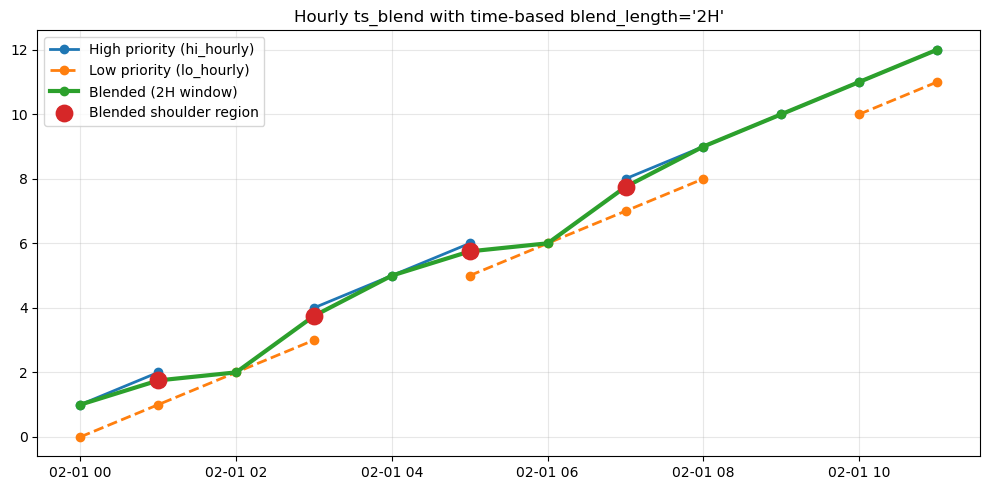

,hi_hourly,lo_hourly,blended
2023-02-01 00:00:00,1.0,0.0,1.00
2023-02-01 01:00:00,2.0,1.0,1.75
2023-02-01 02:00:00,NaN,2.0,2.00
2023-02-01 03:00:00,4.0,3.0,3.75
2023-02-01 04:00:00,5.0,NaN,5.00
2023-02-01 05:00:00,6.0,5.0,5.75
2023-02-01 06:00:00,NaN,6.0,6.00
2023-02-01 07:00:00,8.0,7.0,7.75
2023-02-01 08:00:00,9.0,8.0,9.00
2023-02-01 09:00:00,10.0,NaN,10.00


In [31]:
# Time-based example with hourly data

idx_h = pd.date_range("2023-02-01", periods=12, freq="h")

hi_h = pd.Series(
    [1, 2, np.nan, 4, 5, 6, np.nan, 8, 9, 10, 11, 12],
    index=idx_h,
    name="hi_hourly",
)
lo_h = pd.Series(
    [0, 1, 2, 3, np.nan, 5, 6, 7, 8, np.nan, 10, 11],
    index=idx_h,
    name="lo_hourly",
)

out_h = ts_blend((hi_h, lo_h), blend_length="2h",names="blended")

shoulder_mask_h = (~hi_h.isna()) & (~lo_h.isna()) & (out_h != hi_h)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hi_h.index, hi_h.values, "o-", label="High priority (hi_hourly)", linewidth=2)
ax.plot(lo_h.index, lo_h.values, "o--", label="Low priority (lo_hourly)", linewidth=2)
ax.plot(out_h.index, out_h.values, "o-", label="Blended (2H window)", linewidth=3)

ax.scatter(
    out_h.index[shoulder_mask_h],
    out_h.values[shoulder_mask_h],
    s=140,
    color="tab:red",
    zorder=5,
    label="Blended shoulder region",
)

ax.set_title("Hourly ts_blend with time-based blend_length='2H'")
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

pd.DataFrame({"hi_hourly": hi_h, "lo_hourly": lo_h, "blended": out_h})
